In [1]:
from __init__ import *

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Generate GT

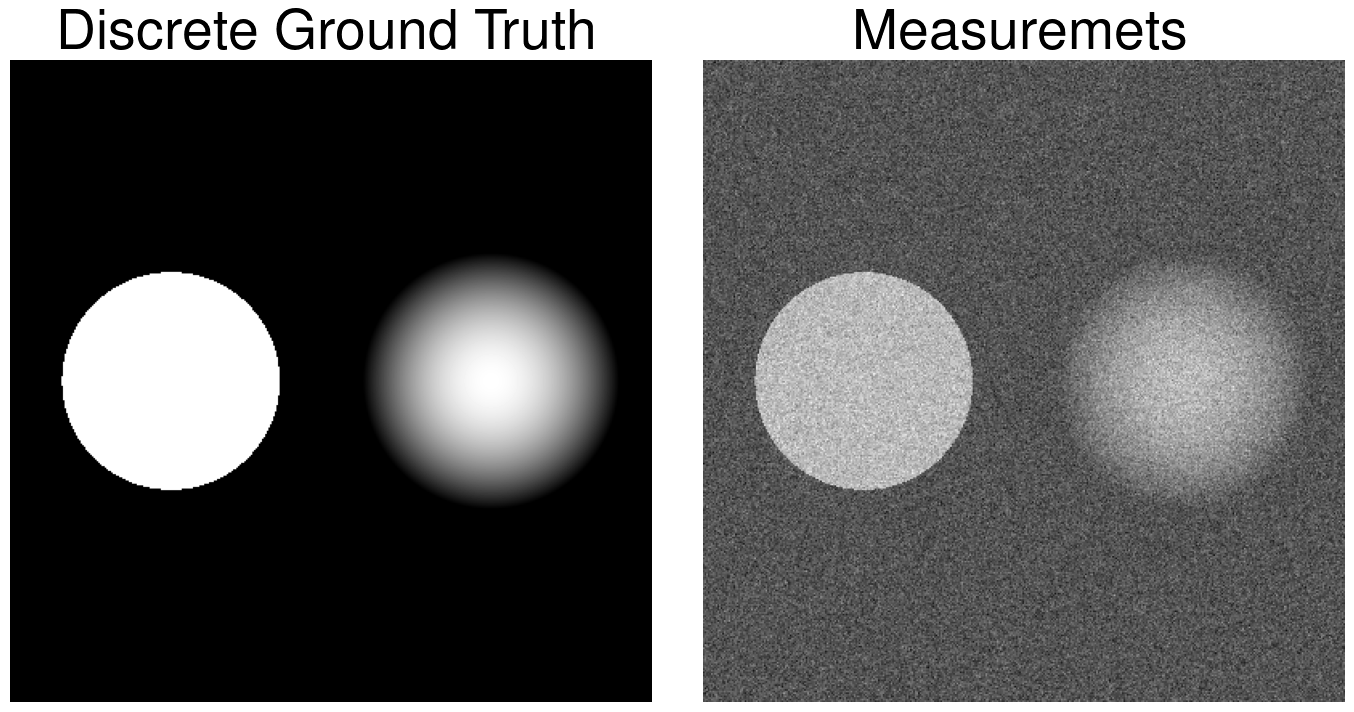

In [3]:
torch.manual_seed(2024)
device = 'cpu'
N1 = N2 = 400
coords = create_grid_coords_neq(0, 1, N1, N2)

dist = np.sqrt((coords[:, 0] - 0.5)**2 + (coords[:, 1] - 0.75)**2).reshape(N1, N2).numpy()
disk = np.zeros_like(dist)
disk[dist <= 0.2] = 1 
r1 = disk * (1 - (dist**2 / (0.2)**2))

dist = np.sqrt((coords[:, 0] - 0.5)**2 + (coords[:, 1] - 0.25)**2).reshape(N1, N2).numpy()
disk = np.zeros_like(dist)
disk[dist <= 0.17] = 1 
r2 = disk

disk = r1 + r2 

s = int((N1) / 400 * 30)
#disk[N1//2 + s: -(s), N1//4 + s:-(N1//4 + s)] = 1 # r3

gt =  torch.from_numpy(disk).double().to(device).view(1, 1, N1, N2) 
y = gt + torch.normal(0, 50/255, gt.size()).double().to(device)

torch.save(gt, 'ExpB/part1/gt.pt')
torch.save(y, 'ExpB/part1/y.pt')


plt.figure(figsize=(14, 7))
plt.subplot(121); plt.axis('off'); plt.title('Discrete Ground Truth', fontsize=40)
plt.imshow(gt[0, 0].cpu(), cmap='gray')
plt.subplot(122); plt.axis('off')
plt.imshow(y[0, 0].cpu(), cmap='gray'); plt.title('Measuremets', fontsize=40)
plt.tight_layout()
plt.savefig('ExpB/part1/saved_figs/signal_and_noisy.pdf', bbox_inches='tight')
plt.show()

# Load Results

In [4]:
for stop in [1e-6]:

    sols = list()
    losses = list()
    times_gpu = list()
    times_cpu = list()
    iterations_gpu = list()
    iterations_cpu = list()
    
    if stop == -1:
        stop_str = ''
    else:
        stop_str = str(stop)
    for prox_gen in [prox_tv_iso, prox_tv_upwind, prox_tv_l2_inexact, prox_htv_svd, prox_htv_inexact]:
        sol = torch.load('ExpB/part1/sol_' + prox_gen.__name__ + '_' + 'gpu' + stop_str + '.pt')
        loss = torch.load('ExpB/part1/loss_' + prox_gen.__name__ + '_' + 'gpu' + stop_str + '.pt')
        time_gpu =  np.round(torch.load('ExpB/part1/time_' + prox_gen.__name__ + '_' + 'gpu' + stop_str + '.pt'), 2)
        time_cpu = np.round(torch.load('ExpB/part1/time_' + prox_gen.__name__ + '_' + 'cpu' + stop_str + '.pt'), 2)

        if stop > 0:
            iters_gpu = torch.load('ExpB/part1/iters_' + prox_gen.__name__ + '_' + 'gpu' + stop_str + '.pt')
            iters_cpu = torch.load('ExpB/part1/iters_' + prox_gen.__name__ + '_' + 'cpu' + stop_str + '.pt')
            
        elif stop == -1:
            iters_gpu = iters_cpu = 20000
        
        iterations_gpu.append(iters_gpu); iterations_cpu.append(iters_cpu)

        sols.append(sol.cpu()); times_cpu.append(time_cpu); losses.append(loss); times_gpu.append(time_gpu) 

    print('Stop Cond:', stop)
    print('CPU Times:', times_cpu)
    print('GPU Times:', times_gpu)
    print('Iterations:', iterations_gpu)

Stop Cond: 1e-06
CPU Times: [9.26, 11.7, 19.15, 97.58, 3.63]
GPU Times: [0.1, 0.17, 0.16, 26.47, 0.87]
Iterations: [165, 193, 172, 7319, 259]


In [5]:
sol_tv_iso = sols[0]
sol_upwind = sols[1]
sol_cpwl_iso = sols[2]
sol_htv_svd = sols[3]
sol_cpwl_htv = sols[4]

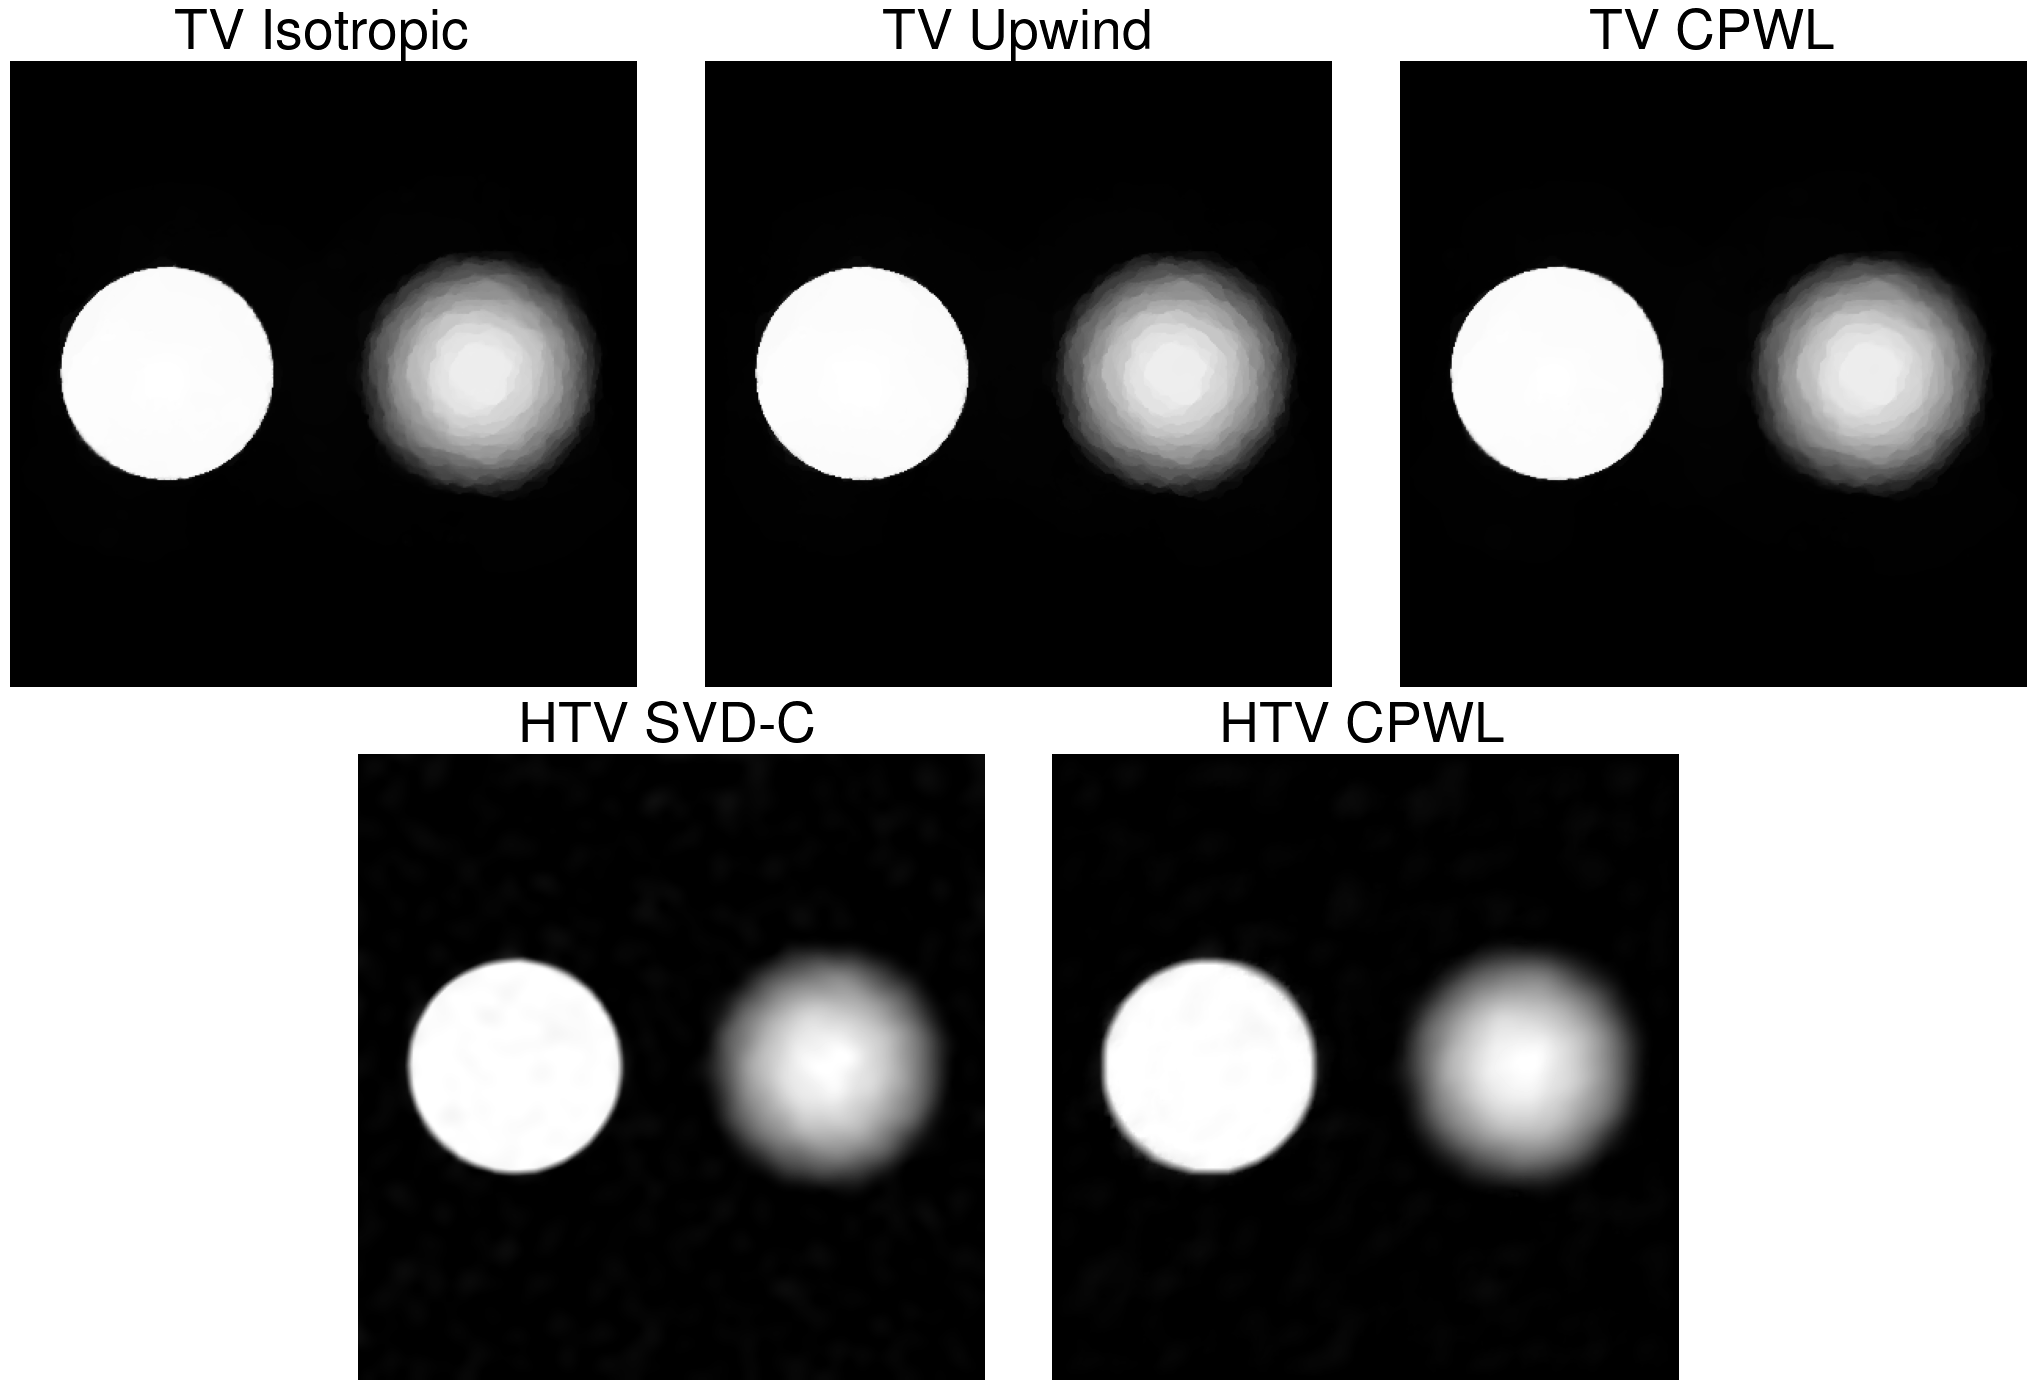

In [6]:
plt.figure(figsize=(21, 14))
r= 4; fd=40
a=0; b =1; 
plt.subplot(2, 6, (1, 2))
plt.imshow((sol_tv_iso).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('TV Isotropic', fontsize=fd)
plt.subplot(2, 6, (3, 4))
plt.imshow((sol_upwind).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('TV Upwind', fontsize=fd)
plt.subplot(2, 6, (5, 6))
plt.imshow((sol_cpwl_iso).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('TV CPWL', fontsize=fd)
plt.subplot(2, 6, (8, 9))
plt.imshow((sol_htv_svd).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('HTV SVD-C', fontsize=fd)
plt.subplot(2, 6, (10, 11))
plt.imshow((sol_cpwl_htv).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('HTV CPWL', fontsize=fd)
plt.tight_layout()
plt.savefig('ExpB/part1/saved_figs/discrete_methods.pdf', bbox_inches='tight')
plt.show()

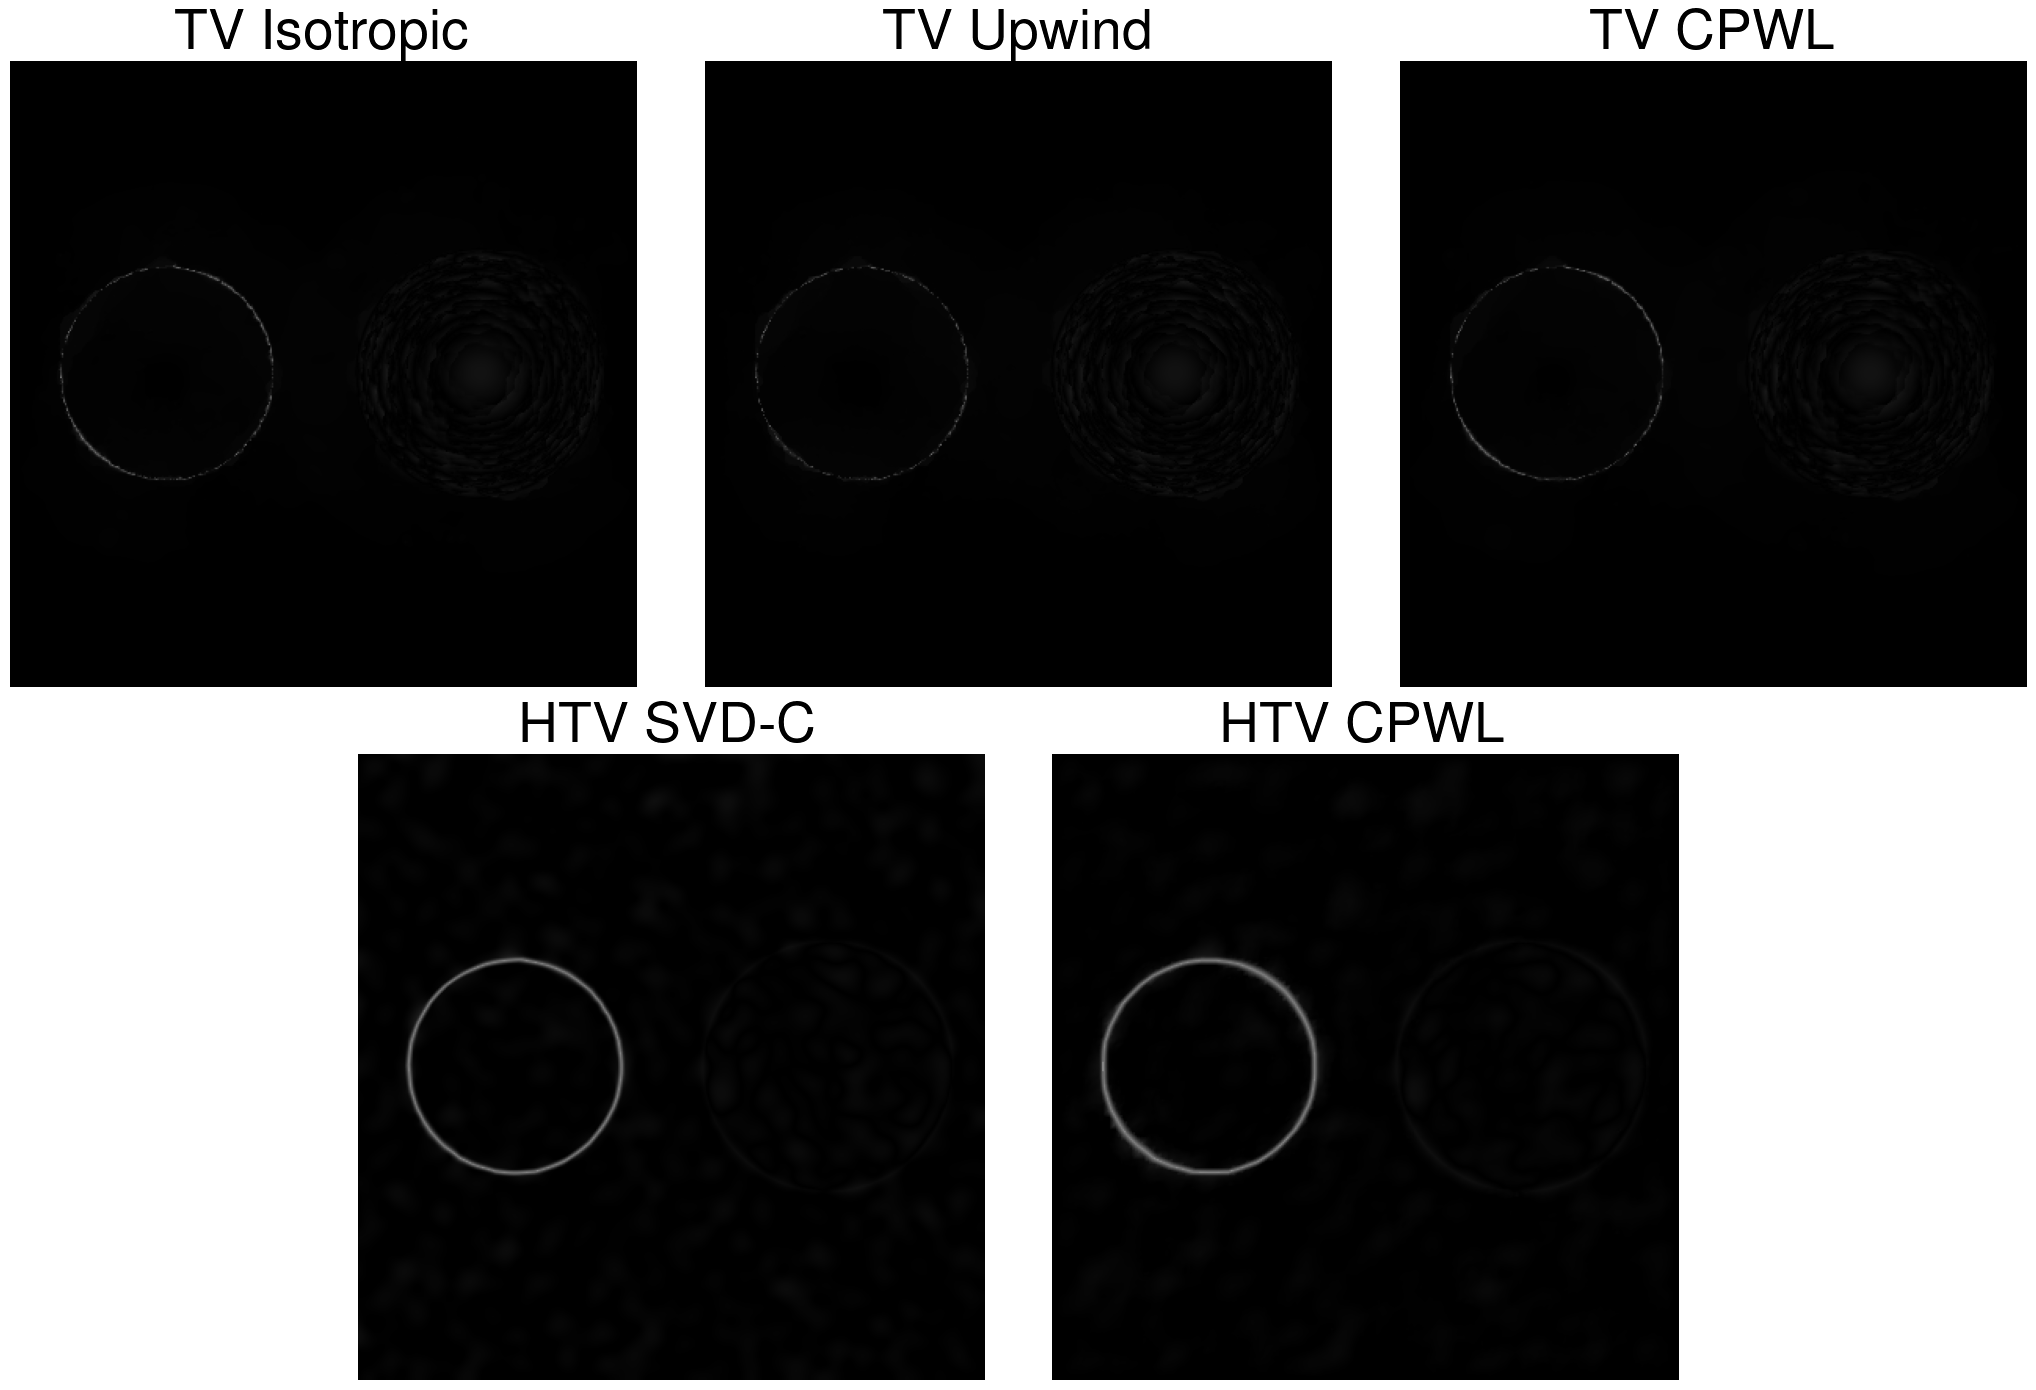

In [7]:
plt.figure(figsize=(21, 14))
r= 4
a=0; b =1; c1=0
plt.subplot(2, 6, (1, 2))
plt.imshow((sol_tv_iso-gt).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('TV Isotropic', fontsize=fd)
plt.subplot(2, 6, (3, 4))
plt.imshow((sol_upwind-gt).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('TV Upwind', fontsize=fd)
plt.subplot(2, 6, (5, 6))
plt.imshow((sol_cpwl_iso-gt).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('TV CPWL', fontsize=fd)
plt.subplot(2, 6, (8, 9))
plt.imshow((sol_htv_svd-gt).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('HTV SVD-C', fontsize=fd)
plt.subplot(2, 6, (10, 11))
plt.imshow((sol_cpwl_htv-gt).abs()[0, 0].cpu(), cmap='gray', vmin=a, vmax=b); plt.axis('off'); plt.title('HTV CPWL', fontsize=fd)
plt.tight_layout()
plt.savefig('ExpB/part1/saved_figs/discrete_methods_residual.pdf', bbox_inches='tight')
plt.show()

--------dik--------


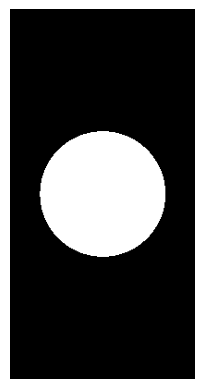

34.18
36.14
34.26
26.45
25.17
--------cone--------


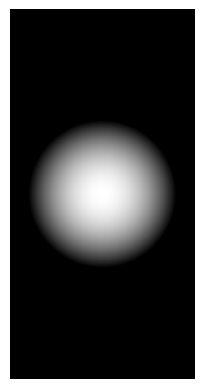

36.79
36.5
36.88
38.22
39.36


In [9]:
N = N1//2

print('--------dik--------')
plt.imshow(gt[0, 0, :, :N].cpu(), cmap='gray'); plt.axis('off'); plt.show()
print(np.round(compute_PSNR(gt[..., :, :N], sol_tv_iso[..., :, :N], 1), 2))
print(np.round(compute_PSNR(gt[..., :, :N], sol_upwind[..., :, :N], 1), 2))
print(np.round(compute_PSNR(gt[..., :, :N], sol_cpwl_iso[..., :, :N], 1), 2))
print(np.round(compute_PSNR(gt[..., :, :N], sol_htv_svd[..., :, :N], 1), 2))
print(np.round(compute_PSNR(gt[..., :, :N], sol_cpwl_htv[..., :, :N], 1), 2))

print('--------cone--------')
plt.imshow(gt[0, 0, :, N:].cpu(), cmap='gray'); plt.axis('off'); plt.show()
print(np.round(compute_PSNR(gt[..., :, N:], sol_tv_iso[..., :, N:], 1), 2))
print(np.round(compute_PSNR(gt[..., :, N:], sol_upwind[..., :, N:], 1), 2))
print(np.round(compute_PSNR(gt[..., :, N:], sol_cpwl_iso[..., :, N:], 1), 2))
print(np.round(compute_PSNR(gt[..., :, N:], sol_htv_svd[..., :, N:], 1), 2))
print(np.round(compute_PSNR(gt[..., :, N:], sol_cpwl_htv[..., :, N:], 1), 2))